In [2]:
%pip install git+https://github.com/mathause/regionmask.git
%pip install git+https://github.com/jbusecke/cmip6_preprocessing.git

Lets import ocean temperature data from a variety of models to see if the masking works well.

In [13]:
# Import packages, install missing ones in current environment
import regionmask
import intake
import matplotlib.pyplot as plt
from cmip6_preprocessing.preprocessing import combined_preprocessing
import xarray as xr
import numpy as np
import cartopy.crs as ccrs
from xmip.regionmask import merged_mask
from cmip6_preprocessing.regionmask import merged_mask

In [17]:
# import example cloud datasets
col_url = "https://raw.githubusercontent.com/NCAR/intake-esm-datastore/master/catalogs/pangeo-cmip6.json"

# Open the catalog using intake
col = intake.open_esm_datastore(col_url)

# Define the search criteria: get model output for the historical period for model with source_id = "CAMS-CSM1-0"
cat = col.search(source_id=['CAMS-CSM1-0'],
                 experiment_id='historical', variable_id='thetao')

# Load the dataset into a dictionary and apply xmip preprocessing 
data_dict = cat.to_dataset_dict(zarr_kwargs={'consolidated': "True", 'decode_times': "False"},
                                preprocess=combined_preprocessing)


--> The keys in the returned dictionary of datasets are constructed as follows:
	'activity_id.institution_id.source_id.experiment_id.table_id.grid_label'


done


First we need to load the natural earth ocean basins.

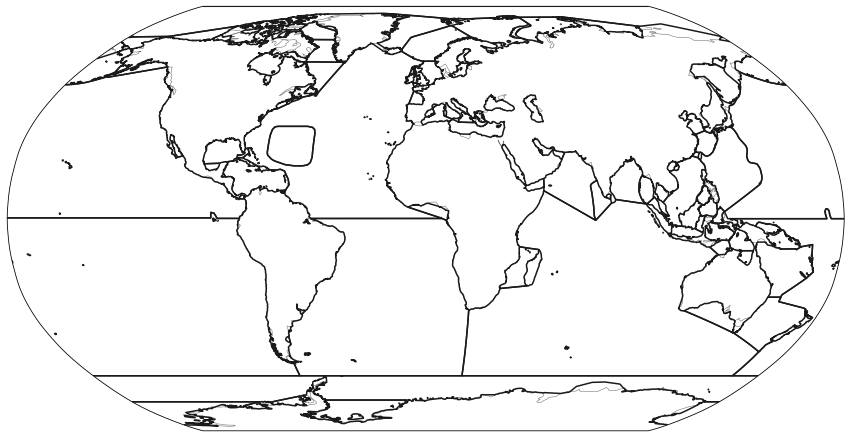

In [7]:
# Obtain the ocean basin mask
basins = regionmask.defined_regions.natural_earth_v4_1_0.ocean_basins_50
f, ax = plt.subplots(subplot_kw=dict(projection=ccrs.Robinson()), figsize=(15,15))
basins.plot(add_ocean=False, add_label=False, ax=ax)
plt.savefig('basin.png', dpi=300)

When using the defaults this will index the North and South Pacific with numeric values of 2 and 3 respectively. The Maritime Continent gets a separate index (4). We will now load example data from many CMIP6 models, create the mask, and select only the points with values 2,3, and 4.

/Users/SamuelOmanchi/opt/miniconda3/lib/python3.8/site-packages/pygeos/io.py:379: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  arr[:] = geometry
/Users/SamuelOmanchi/opt/miniconda3/lib/python3.8/site-packages/cartopy/crs.py:825: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  if len(multi_line_string) > 1:
/Users/SamuelOmanchi/opt/miniconda3/lib/python3.8/site-packages/cartopy/crs.py:877: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for line in multi_line_string:
/Users/SamuelOmanchi/opt/miniconda3/lib

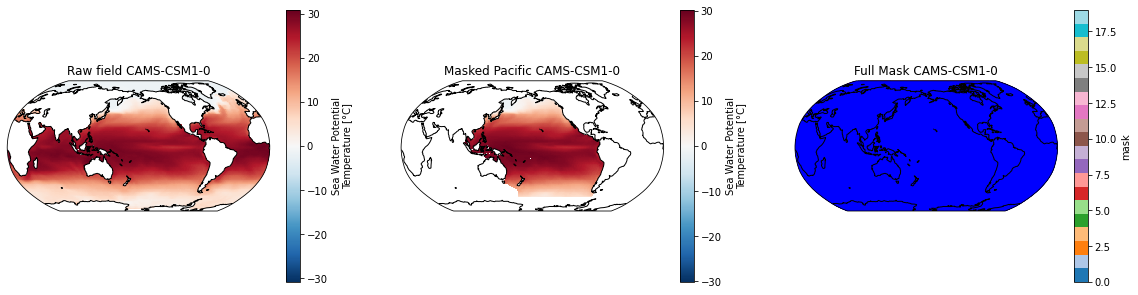

In [21]:
# loop over models and mask out the pacific
for k, ds in data_dict.items():
    if 'lev' in ds.dims:
        model = ds.attrs['source_id']
        if 'member_id' in ds.dims:
            ds = ds.isel(member_id=0)
        ds = ds.thetao.isel(time=0, lev=0).squeeze()

        mask = merged_mask(basins,ds)

        kwargs = dict(x='lon', y='lat',transform = ccrs.PlateCarree(), infer_intervals=False)
        fig, (ax1, ax2, ax3) = plt.subplots(ncols=3, figsize=[20,5], subplot_kw={'projection':ccrs.Robinson(190)})
        ds.plot(ax=ax1, **kwargs)
        ax1.set_title(f"Raw field {model}")
        
        ds_masked = ds.where(np.logical_or(np.logical_or(mask == 2, mask==3),mask==4)) # Pacific + Maritime Continent
        ds_masked.plot(ax=ax2, **kwargs)
        ax2.set_title(f"Masked Pacific {model}")
        mask.plot(ax=ax3, cmap='tab20', vmin=0, vmax=19, **kwargs)
        ax3.set_title(f"Full Mask {model}")
        for ax in [ax1, ax2, ax3]:
            ax.coastlines()

In [9]:
ds


<xarray.DataArray 'thetao' (y: 384, x: 320)>
dask.array<getitem, shape=(384, 320), dtype=float32, chunksize=(384, 320), chunktype=numpy.ndarray>
Coordinates:
    time       object 1850-01-16 12:00:00
  * x          (x) int32 1 2 3 4 5 6 7 8 9 ... 313 314 315 316 317 318 319 320
  * y          (y) int32 1 2 3 4 5 6 7 8 9 ... 377 378 379 380 381 382 383 384
    lat        (y, x) float64 dask.array<chunksize=(384, 320), meta=np.ndarray>
    lev        float64 0.0
    lon        (y, x) float64 dask.array<chunksize=(384, 320), meta=np.ndarray>
    member_id  <U9 'r10i1p1f1'
Attributes:
    cell_measures:  area: areacello volume: volcello
    cell_methods:   area: mean where sea time: mean
    comment:        Diagnostic should be contributed even for models using co...
    history:        2019-09-17T23:50:37Z altered by CMOR: Converted type from...
    long_name:      Sea Water Potential Temperature
    original_name:  templvl
    standard_name:  sea_water_potential_temperature
    units:          °C